In [2]:
# Import Modules

import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("http://www.football-data.co.uk/englandm.php")

    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')

    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]

    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]

    data_urls = []

    # Create a list of links
    prefix = 'http://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])

    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-12]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]

        print(f"Getting data for season {season}")

        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season

        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())

        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)

    # Drop all NAs
    df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")

    return df

In [4]:
df = grab_epl_data()
# df.to_csv("data/epl_data.csv", index=False)

Getting data for season 1920
Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Getting data for season 0506
Finished grabbing data.


In [6]:
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

# Home Team Advantage

In [7]:
win_rates = \
(df.groupby('season')
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']])

win_rates

,homeWin,draw,awayWin
season,,,
0506,0.505263,0.202632,0.292105
0607,0.477573,0.258575,0.263852
0708,0.463158,0.263158,0.273684
0809,0.453826,0.255937,0.290237
0910,0.507895,0.252632,0.239474
1011,0.471053,0.292105,0.236842
1112,0.450000,0.244737,0.305263
1213,0.433862,0.285714,0.280423
1314,0.472973,0.208108,0.318919


# Win Rate 

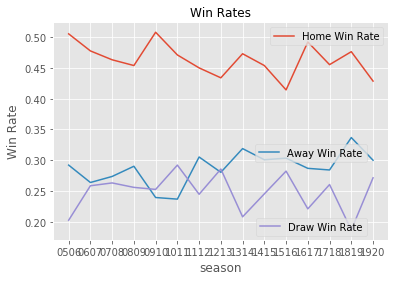

In [10]:
# Set the style
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

home_line = ax.plot(win_rates.homeWin, label='Home Win Rate')
away_line = ax.plot(win_rates.awayWin, label='Away Win Rate')
draw_line = ax.plot(win_rates.draw, label='Draw Win Rate')
ax.set_xlabel("season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=12)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.4))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.95, 0.06))

In [11]:
big_clubs = ['Liverpool', 'Man City', 'Man United', 'Chelsea', 'Arsenal']
home_win_rates_5 = df[df.HomeTeam.isin(big_clubs)].groupby(['HomeTeam', 'season']).homeWin.mean()
away_win_rates_5 = df[df.AwayTeam.isin(big_clubs)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United
season,,,,,
0506,0.421053,0.368421,0.263158,0.263158,0.052632
0607,0.263158,0.000000,0.421053,-0.052632,0.105263
0708,0.210526,-0.052632,0.157895,0.368421,0.368421
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526
0910,0.368421,0.368421,0.421053,0.315789,0.263158
1011,0.157895,0.368421,0.368421,0.263158,0.684211
1112,0.157895,0.315789,-0.105263,0.421053,0.105263
1213,0.052632,0.105263,0.105263,0.248538,0.201754
1314,0.143275,0.251462,0.307018,0.362573,-0.026316


# Variable Correlation

In [18]:
df['margin'] = df['FTHG'] - df['FTAG']
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = df[stat_cols].corr()
stat_correlations['margin'].sort_values()



AST      -0.350754
AS       -0.300414
HY       -0.148168
HR       -0.130227
AC       -0.076664
HF       -0.063493
AF        0.004905
AY        0.009702
HC        0.073943
AR        0.099007
HS        0.277740
HST       0.371271
margin    1.000000
Name: margin, dtype: float64

C:\Users\adial\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


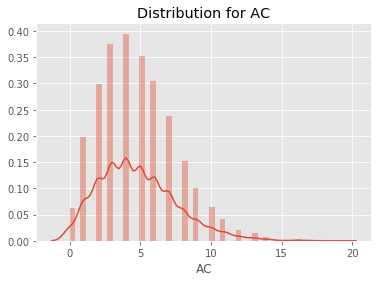

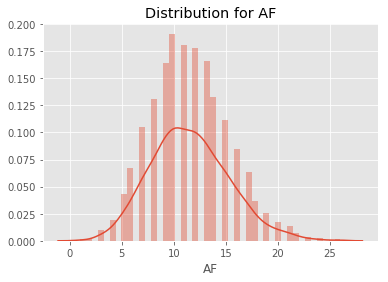

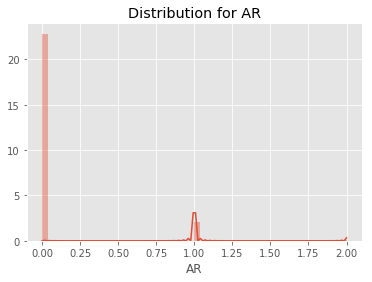

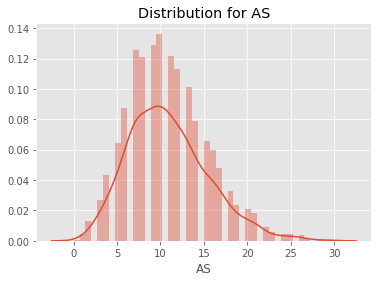

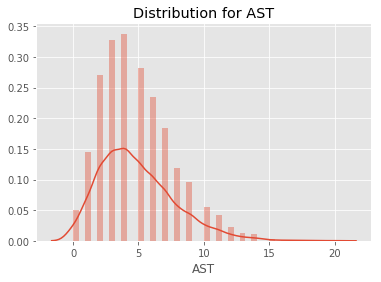

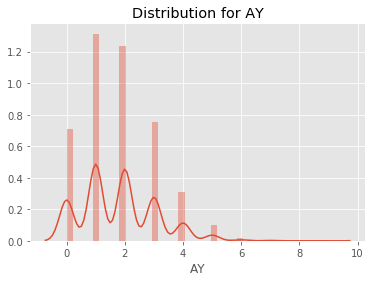

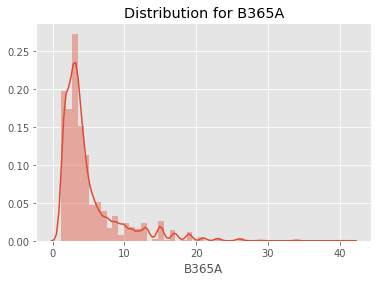

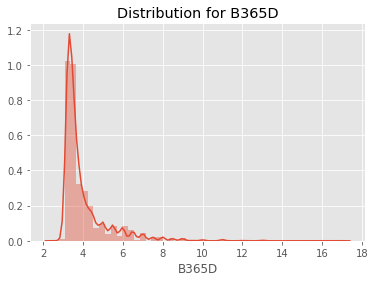

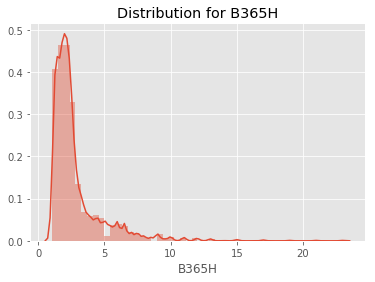

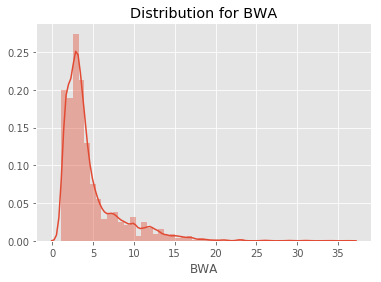

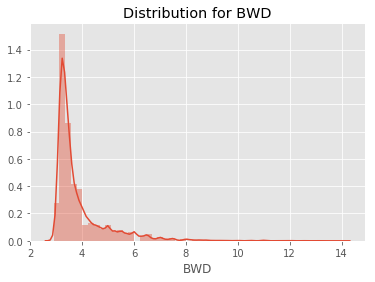

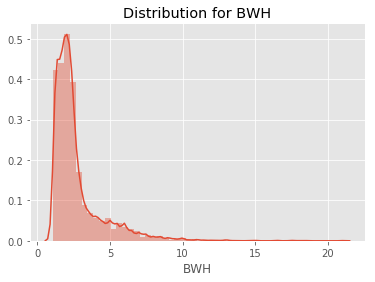

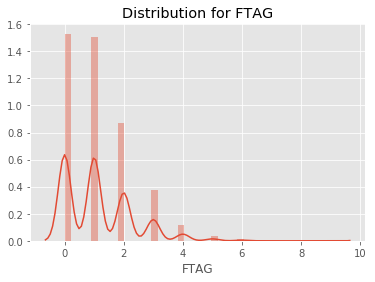

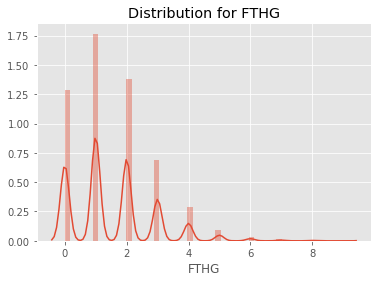

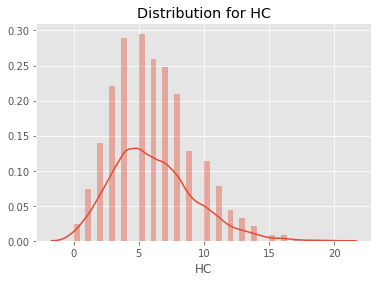

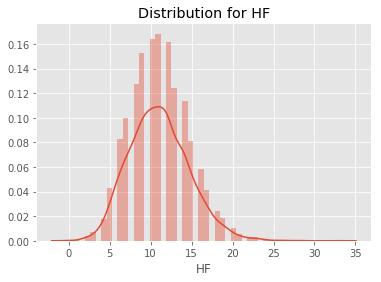

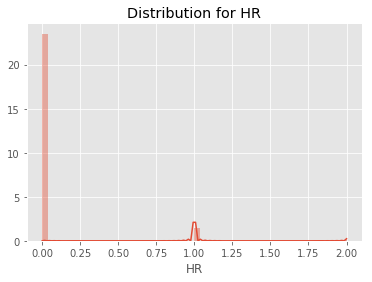

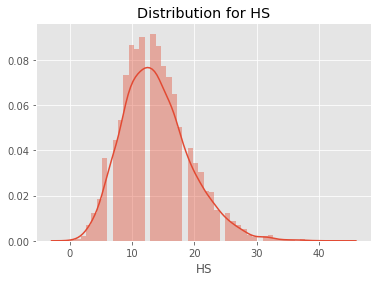

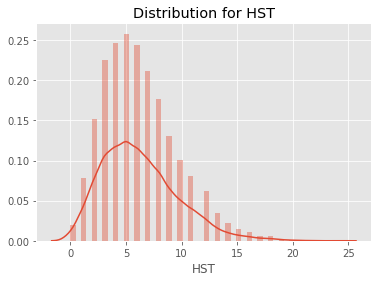

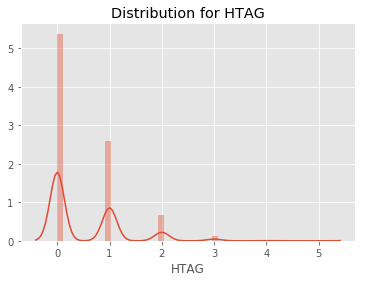

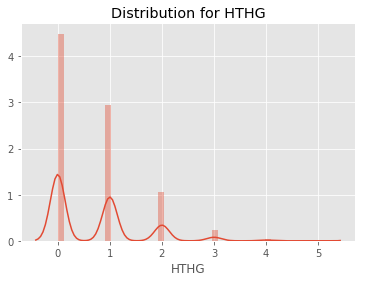

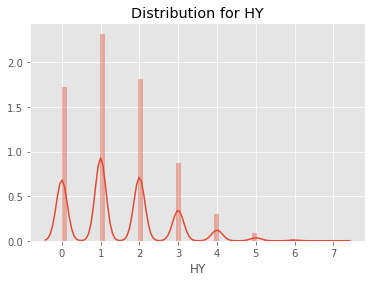

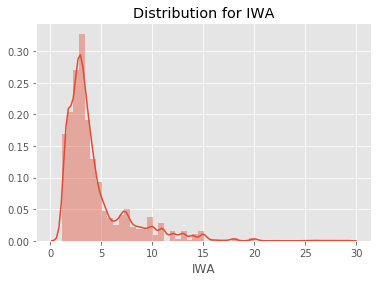

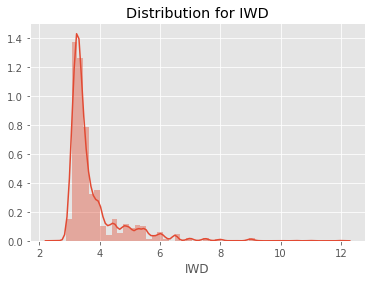

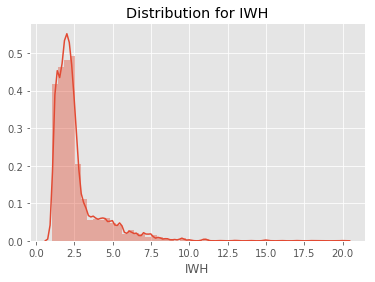

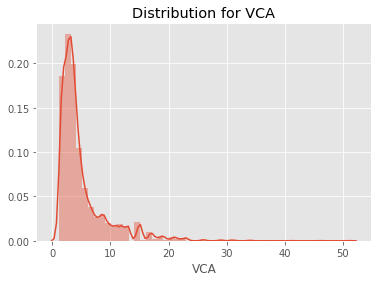

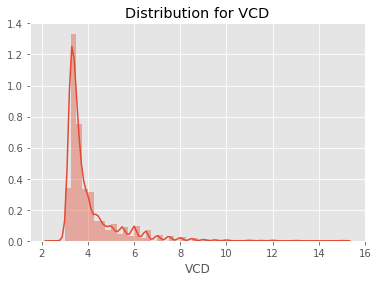

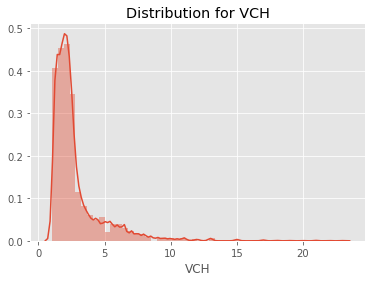

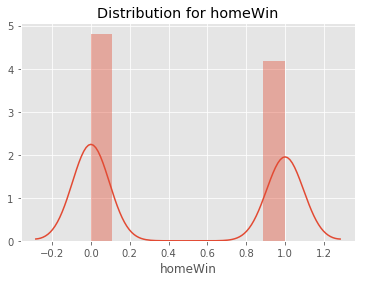

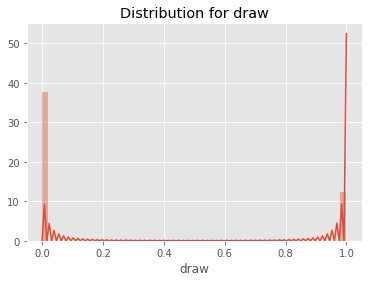

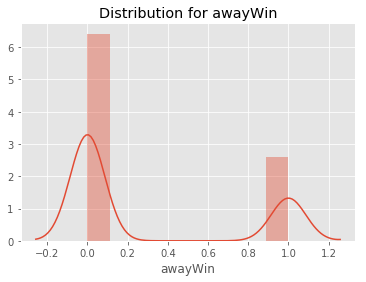

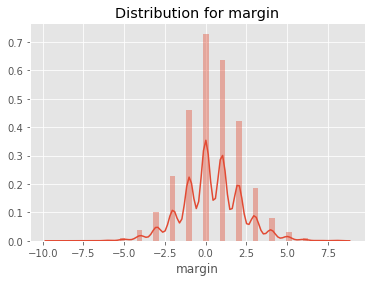

In [19]:
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution for {col}")
    plt.show()

# Data Modeling

In [16]:
# Import libraries
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)


In [17]:
# This table includes all of our data in one big DataFrame
df = create_df('data/epl_data.csv')
df.head(3)

NameError: name 'create_df' is not defined